In [2]:
import os
import glob
import os
import nibabel as nib
import numpy as np
from matplotlib import pyplot as plt

os.environ["CUDA_VISIBLE_DEVICES"]="7"

In [3]:
from keras.models import Sequential
from keras.layers import Conv3D, Activation, MaxPooling3D, BatchNormalization, Flatten, Dropout, Dense, GaussianNoise
from keras.optimizers import Adam
from keras.utils import np_utils
from keras.losses import binary_crossentropy
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator as IDG

In [4]:
def Get_data(paths):
    hdr = []
    data = []
    label = []
    for path in paths:
        if os.path.isdir(path) is True:
            pathnow = os.path.join(path)
            data_path = glob.glob(pathnow + '/*seg.nii.gz')
            nibfile = nib.load(data_path[0])
            data.append(nibfile.get_data())
            hdr.append(nibfile.header)
    return np.array(data), hdr

In [5]:
paths = glob.glob('/data/BraTS/BraTS17/MICCAI_BraTS17_Data_Training/HGG/*')
data_HGG, hdr_HGG = Get_data(paths)
paths = glob.glob('/data/BraTS/BraTS17/MICCAI_BraTS17_Data_Training/LGG/*')
data_LGG, hdr_LGG = Get_data(paths)

label = np.zeros((285))
label[0:len(data_HGG)] = 1
label[len(data_HGG):len(data_HGG) + len(data_LGG)] = 0

In [6]:
data = np.concatenate((data_HGG, data_LGG))/4.0

In [21]:
data[0].shape

(240, 240, 155)

In [7]:
# def Segmet(img, up, down, axis):
#     for i in range(up):
#         img = np.delete(img, 90 - up, axis)
#     for i in range(down):
#         img = np.delete(img, 0, axis)
#     return img

In [8]:
# data = Segmet(data, 20, 20, 1)
# data = Segmet(data, 20, 20, 2)
# data = Segmet(data, 20, 20, 3)

In [35]:
data.shape

(285, 200, 200, 115)

In [36]:
# data_train = data.reshape((285,200,200,115,1))

In [7]:
data_train = data.reshape((285,240,240,155,1))

In [8]:
X_train, X_test, y_train, y_test = train_test_split(data_train, label, test_size = 0.2)

In [38]:
X_train.shape[1:]

(200, 200, 115, 1)

In [12]:
def plot_image(img, x, y, z):
    plt.subplot(131)
    plt.imshow(img[::,::,z])
    plt.subplot(132)
    plt.imshow(img[::,y,::])
    plt.subplot(133)
    plt.imshow(img[x,::,::])

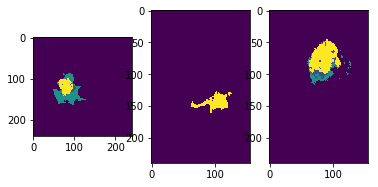

In [18]:
plot_image(data[5], 120, 120, 70)

In [18]:
def model():
    
    model = Sequential()
    model.add(Conv3D(8, kernel_size=(2,2,2), input_shape=(X_train.shape[1:]), activation='relu'))
    model.add(MaxPooling3D(pool_size=([2,2,2])))
    
    model.add(Conv3D(32, kernel_size=(2,2,2), activation='relu'))
    model.add(MaxPooling3D(pool_size=([2,2,2])))
    
    model.add(Conv3D(64, kernel_size=(2,2,2), activation='relu'))
    model.add(MaxPooling3D(pool_size=([2,2,2])))
    
    model.add(Conv3D(128, kernel_size=([2,2,2]), activation='relu'))
    model.add(MaxPooling3D(pool_size=([3,3,3])))
    
    model.add(Conv3D(256, kernel_size=(2,2,2), activation='relu'))
    model.add(MaxPooling3D(pool_size=([3,3,3])))
    
    model.add(GaussianNoise(0.001))
    model.add(Flatten())
    #model.add(BatchNormalization())

    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(1, activation='sigmoid'))
   
    model.compile(loss='binary_crossentropy', optimizer='Adam', metrics=['accuracy'])
    
    return model

In [19]:
model = model()

In [26]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_1 (Conv3D)            (None, 239, 239, 154, 16) 144       
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 119, 119, 77, 16)  0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 118, 118, 76, 32)  4128      
_________________________________________________________________
max_pooling3d_2 (MaxPooling3 (None, 59, 59, 38, 32)    0         
_________________________________________________________________
conv3d_3 (Conv3D)            (None, 58, 58, 37, 64)    16448     
_________________________________________________________________
max_pooling3d_3 (MaxPooling3 (None, 29, 29, 18, 64)    0         
_________________________________________________________________
conv3d_4 (Conv3D)            (None, 28, 28, 17, 128)   65664     
__________

In [32]:
hist = model.fit(X_train,
                 y_train,
                 validation_split=0.2,
                 batch_size = 10,
                 epochs = 10,
                 #callbacks = [early_stopping],
                 shuffle=True)

Train on 182 samples, validate on 46 samples
Epoch 1/10
182/182 [==============================] - 75s 412ms/step - loss: 0.6199 - acc: 0.7088 - val_loss: 0.5902 - val_acc: 0.6304
Epoch 2/10
182/182 [==============================] - 52s 287ms/step - loss: 0.5094 - acc: 0.7308 - val_loss: 0.5715 - val_acc: 0.6304
Epoch 3/10
182/182 [==============================] - 52s 288ms/step - loss: 0.4451 - acc: 0.7308 - val_loss: 0.4997 - val_acc: 0.6522
Epoch 4/10
 40/182 [=====>........................] - ETA: 36s - loss: 0.3665 - acc: 0.8500

KeyboardInterrupt: 

In [15]:
def save_history(history, result_dir):
    loss = history.history['loss']
    acc = history.history['acc']
    val_loss = history.history['val_loss']
    val_acc = history.history['val_acc']
    nb_epoch = len(acc)

    with open(os.path.join(result_dir, 'result.txt'), 'w') as fp:
        fp.write('epoch\tloss\tacc\tval_loss\tval_acc\n')
        for i in range(nb_epoch):
            fp.write('{}\t{}\t{}\t{}\t{}\n'.format(
                i, loss[i], acc[i], val_loss[i], val_acc[i]))

In [24]:
def plot_history(history):
    plt.plot(history.history['acc'], marker='.')
    plt.plot(history.history['val_acc'], marker='.')
    plt.title('model accuracy')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.grid()
    plt.legend(['acc', 'val_acc'], loc='lower right')
    plt.savefig('./../result/model_accuracy.png')
    plt.close()

    plt.plot(history.history['loss'], marker='.')
    plt.plot(history.history['val_loss'], marker='.')
    plt.title('model loss')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.grid()
    plt.legend(['loss', 'val_loss'], loc='upper right')
    plt.savefig('./../result/model_loss.png')
    plt.close()

In [25]:
plot_history(hist)

In [78]:
def plot_now(history):
    plt.subplot(121)
    plt.plot(history.history['acc'], marker='.')
    plt.plot(history.history['val_acc'], marker='.')
    plt.title('model accuracy')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.grid()
    plt.legend(['acc', 'val_acc'], loc='lower right')

    plt.subplot(122)
    plt.plot(history.history['loss'], marker='.')
    plt.plot(history.history['val_loss'], marker='.')
    plt.title('model loss')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.grid()
    plt.legend(['loss', 'val_loss'], loc='upper right')

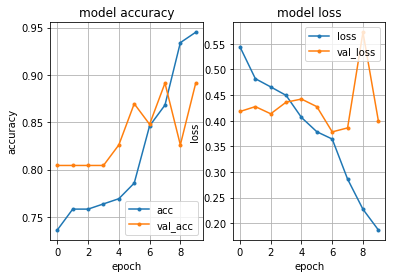

In [79]:
plot_now(hist)

In [81]:
loss, acc = model.evaluate(X_test, y_test, verbose=0)

ResourceExhaustedError: OOM when allocating tensor with shape[32,8,239,239,154]
	 [[Node: conv3d_33/convolution = Conv3D[T=DT_FLOAT, data_format="NDHWC", padding="VALID", strides=[1, 1, 1, 1, 1], _device="/job:localhost/replica:0/task:0/device:GPU:0"](_arg_conv3d_33_input_0_0/_759, conv3d_33/kernel/read)]]
	 [[Node: metrics_5/acc/Mean_1/_771 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_191_metrics_5/acc/Mean_1", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]

Caused by op u'conv3d_33/convolution', defined at:
  File "/home/u/chengen/anaconda2/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/home/u/chengen/anaconda2/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/home/u/chengen/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/u/chengen/anaconda2/lib/python2.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/u/chengen/anaconda2/lib/python2.7/site-packages/ipykernel/kernelapp.py", line 478, in start
    self.io_loop.start()
  File "/home/u/chengen/anaconda2/lib/python2.7/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/home/u/chengen/anaconda2/lib/python2.7/site-packages/tornado/ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "/home/u/chengen/anaconda2/lib/python2.7/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/u/chengen/anaconda2/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/home/u/chengen/anaconda2/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/home/u/chengen/anaconda2/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/home/u/chengen/anaconda2/lib/python2.7/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/u/chengen/anaconda2/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/home/u/chengen/anaconda2/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "/home/u/chengen/anaconda2/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/home/u/chengen/anaconda2/lib/python2.7/site-packages/ipykernel/ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/u/chengen/anaconda2/lib/python2.7/site-packages/ipykernel/zmqshell.py", line 537, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/u/chengen/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2718, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/u/chengen/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2822, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/u/chengen/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2882, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-77-612025cf5234>", line 1, in <module>
    model = model()
  File "<ipython-input-76-f5c043cb7efe>", line 4, in model
    model.add(Conv3D(8, kernel_size=(2,2,2), input_shape=(X_train.shape[1:]), activation='relu'))
  File "/home/u/chengen/anaconda2/lib/python2.7/site-packages/keras/models.py", line 464, in add
    layer(x)
  File "/home/u/chengen/anaconda2/lib/python2.7/site-packages/keras/engine/topology.py", line 603, in __call__
    output = self.call(inputs, **kwargs)
  File "/home/u/chengen/anaconda2/lib/python2.7/site-packages/keras/layers/convolutional.py", line 172, in call
    dilation_rate=self.dilation_rate)
  File "/home/u/chengen/anaconda2/lib/python2.7/site-packages/keras/backend/tensorflow_backend.py", line 3370, in conv3d
    data_format=tf_data_format)
  File "/home/u/chengen/anaconda2/lib/python2.7/site-packages/tensorflow/python/ops/nn_ops.py", line 751, in convolution
    return op(input, filter)
  File "/home/u/chengen/anaconda2/lib/python2.7/site-packages/tensorflow/python/ops/nn_ops.py", line 835, in __call__
    return self.conv_op(inp, filter)
  File "/home/u/chengen/anaconda2/lib/python2.7/site-packages/tensorflow/python/ops/nn_ops.py", line 499, in __call__
    return self.call(inp, filter)
  File "/home/u/chengen/anaconda2/lib/python2.7/site-packages/tensorflow/python/ops/nn_ops.py", line 187, in __call__
    name=self.name)
  File "/home/u/chengen/anaconda2/lib/python2.7/site-packages/tensorflow/python/ops/gen_nn_ops.py", line 847, in conv3d
    padding=padding, data_format=data_format, name=name)
  File "/home/u/chengen/anaconda2/lib/python2.7/site-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/home/u/chengen/anaconda2/lib/python2.7/site-packages/tensorflow/python/framework/ops.py", line 2956, in create_op
    op_def=op_def)
  File "/home/u/chengen/anaconda2/lib/python2.7/site-packages/tensorflow/python/framework/ops.py", line 1470, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

ResourceExhaustedError (see above for traceback): OOM when allocating tensor with shape[32,8,239,239,154]
	 [[Node: conv3d_33/convolution = Conv3D[T=DT_FLOAT, data_format="NDHWC", padding="VALID", strides=[1, 1, 1, 1, 1], _device="/job:localhost/replica:0/task:0/device:GPU:0"](_arg_conv3d_33_input_0_0/_759, conv3d_33/kernel/read)]]
	 [[Node: metrics_5/acc/Mean_1/_771 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_191_metrics_5/acc/Mean_1", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]


In [60]:
import pandas as pd

In [74]:
test_pred = X_test[:17]
test_pred = model.predict_classes(test_pred)
test_true = y_test[:17]
test_true = test_true.astype(int)
test_pred = test_pred.squeeze()
pd.crosstab(test_true, test_pred, rownames=['label'], colnames=['predict'])

predict,0,1
label,,
0,5,3
1,0,9


In [75]:
test_pred = X_test[17:34]
test_pred = model.predict_classes(test_pred)
test_true = y_test[17:34]
test_true = test_true.astype(int)
test_pred = test_pred.squeeze()
pd.crosstab(test_true, test_pred, rownames=['label'], colnames=['predict'])

predict,0,1
label,,
0,3,3
1,0,11


In [76]:
test_pred = X_test[34:51]
test_pred = model.predict_classes(test_pred)
test_true = y_test[34:51]
test_true = test_true.astype(int)
test_pred = test_pred.squeeze()
pd.crosstab(test_true, test_pred, rownames=['label'], colnames=['predict'])

predict,0,1
label,,
0,3,5
1,0,9


In [77]:
test_pred = X_test[51:57]
test_pred = model.predict_classes(test_pred)
test_true = y_test[51:57]
test_true = test_true.astype(int)
test_pred = test_pred.squeeze()
pd.crosstab(test_true, test_pred, rownames=['label'], colnames=['predict'])

predict,0,1
label,,
1,1,5


In [65]:
(57-13.0) / 57

0.7719298245614035